  ![alt text](https://gluon-cv.mxnet.io/_static/gluon-logo.svg "Gluon Logo")
  
  #  GluonCV: a Deep Learning Toolkit for Computer Vision

GluonCV provides implementations of state-of-the-art (SOTA) deep learning algorithms in computer vision. It aims to help engineers, researchers, and students quickly prototype products, validate new ideas and learn computer vision.

GluonCV features:

   * training scripts that reproduce SOTA results reported in latest papers,

   * a large set of pre-trained models,

   * carefully designed APIs and easy to understand implementations,

   * community support.

   
![alt text](images/gluoncv.png "Gluoncv Applications")

This notebook will focus on training a <b>custom Object Detection model</b> using the <b>Yolov3</b> network
(custom means we are not using a dataset such as COCO or Pascal VOC)

In order to use the GluonCV library, we must install it by updating the version of mxnet that is installed.
We will also update some paths to the CUDA libraries, a dependency of GluonCV

In [ ]:

# The following lines install GluonCV onto our Notebook instance.  
# While we are *NOT* training on this instance we want GluonCV installed to explore the API
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda-10.0/lib64/
!export PATH=/usr/local/cuda-10.0/bin${PATH:+:${PATH}}
!pip install mxnet-cu101
!pip install --upgrade mxnet-cu101 gluoncv
!sudo yum install tree -y # <-- This assumes the notebook is running on a Sagemaker Notebook instance


In [18]:
import boto3                            # AWS Python framework                            
import os                               # OS library to access file paths
from gluoncv import data, utils         # gluoncv data and utils modules to create datasets
from gluoncv.data import VOCDetection   # VOCDetection allows gluoncv to recognize our boundingboxes and classes
from gluoncv.utils import viz           # gluoncv specific visualization capabilities
from matplotlib import pyplot as plt    # visualization capabilites (to view dataset samples)


   We are going to use a PASCAL VOC Dataset for this model.  We will briefly cover the formatting of a VOC Dataset in this notebook, but for more information about PASCAL VOC, visit: https://gluon-cv.mxnet.io/build/examples_datasets/pascal_voc.html#sphx-glr-build-examples-datasets-pascal-voc-py

### Move sample data from S3 to our notebook instance
We have a small sample dataset that we will evaluate on this notebook

In [ ]:
!aws s3 cp --recursive s3://gluoncv-notebook .

In [2]:
# Let us take a look a the directory structure of a typical PASCAL VOC dataset:
!tree VOC

VOC
├── VOCtrain
│   ├── Annotations
│   │   ├── aug3_919323914.xml
│   │   ├── aug3_T079489488.xml
│   │   ├── aug3_T449771735.xml
│   │   ├── aug3_T728515868.xml
│   │   └── aug3_T809161543.xml
│   ├── ImageSets
│   │   └── Main
│   │       └── train.txt
│   └── JPEGImages
│       ├── aug3_919323914.jpg
│       ├── aug3_T079489488.jpg
│       ├── aug3_T449771735.jpg
│       ├── aug3_T728515868.jpg
│       └── aug3_T809161543.jpg
└── VOCvalidate
    ├── Annotations
    │   ├── aug3_046386182.xml
    │   ├── aug3_612934144.xml
    │   ├── aug3_T112765693.xml
    │   ├── aug3_T322712635.xml
    │   └── aug3_T490683172.xml
    ├── ImageSets
    │   └── Main
    │       └── val.txt
    └── JPEGImages
        ├── aug3_046386182.jpg
        ├── aug3_612934144.jpg
        ├── aug3_T112765693.jpg
        ├── aug3_T322712635.jpg
        └── aug3_T490683172.jpg

10 directories, 22 files


For this example, we will use the images and annotations in "VOCvalidate" as our validation dataset and the images and annotations in "VOCtrain" as our training dataset.  The "VOCvalidate" folder could be named anything meaningful. In this example since we have only 1 training and 1 validation dataset we keep the names simple and refer to them as VOCtrain and VOCvalidate, but we will see momentarily why the folders "VOCvalidate" & "VOCtrain" are not synonymous with datasets, instead we will refer to them as VOC Imageset folders. 

**note** The word VOC must be the first three letters of the ImageSet foldernames or the VOCDetection method that will be introduced later will not recognize the folders.

Within each VOC Imageset folder there are 3 child folders:
    Annotations
    ImageSets
    JPEGImages
    
The <b>Annotations<b> folder holds .XML files.  Each XML file contains bounding box information for 1 image file in the dataset. That image file may have multiple objects, but there is a 1:1 relationship between annotation files and imamge files.  Let's look at one of the Annotation files:

In [8]:
!cat VOC/VOCvalidate/Annotations/aug3_046386182.xml

<annotation>
        <folder>VOCvalidate</folder>
        <filename>aug3_046386182.jpg</filename>
        <source>
                <database>Unknown</database>
        </source>
        <size>
                <width>720</width>
                <height>720</height>
                <depth>3</depth>
        </size>
 <object>
                <name>QC</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>223</xmin>
                        <ymin>325</ymin>
                        <xmax>252</xmax>
                        <ymax>401</ymax>
                </bndbox>
        </object>
 <object>
                <name>QC</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>423</xmin>
                        <ymin>564</ymin>
                

In the above annotation file, there are 4 object nodes.  The image (which we will see soon, contains two playing cards. Each playing card has two locations for rank and suite and in this image, all 4 locations are visible.

Each object node contains the class name (QC, 8H) as well as the bounding box for the rank and suite. It is important to note the this model ONLY detects the rank and suite of playing cards, not the entire card or the number of suite icons on the card.

The second child folder is ImageSets. This folder contains text files that list the images you wish to include in a particular dataset. Lets take a look:

In [9]:
!cat VOC/VOCvalidate/ImageSets/Main/val.txt

aug3_046386182
aug3_T112765693
aug3_T490683172
aug3_612934144
aug3_T322712635


When dealing with a VOC dataset for object detection, we use a child folder called "Main" within the ImageSets folder.  If we were using gluoncv for other task such as Action/Event, Pose Detection or Segmentation we would create additional folders at the level of Main and give them names corresponding to the type of model. Within the Main folder is a file called val.txt. It is used to encapsulate the size of the dataset we wish to use by listing each image name. In this example, we only include 5 files.  You will note the file extension is absent.  The PASCAL VOC format will expect to find an annotation file (In the Annotation directory and ending in .xml) of the same name as each entry in this val.txt.  PASCAL VOC will also expect to find an image file of the same name in the JPEGImages directory with a .jpg extension.

This structure allows you to store n files in the annotations and JPEGImages directories, and then customize an ImageSet listing file to only train/validate on selected annotation and JPEGImage files.  This gives you the capability to store as many images as you wish in a single directory, but create separate datasets by creating multiple ImageSet files.

The final directory is the JPEGImages folder which as stated above, contains the corresponding image to the annotations file. We will use the GluonCV API to explore these files further, first however we need to introduce gluoncv to our class structure.

Our dataset has <b>52 classes</b> - corresponding to the 52 different cards in a deck of playing cards (minus the Jokers)
![alt text](images/playingcards.png "Deck of cards")

The class names are abbreviated by first letter of rank and first letter of suite:

    2C = Two of Clubs
    AS = Ace of Spades
    ...

We will create a class derived from the VOCDetection method for our custom dataset:

In [10]:
class VOCLike(VOCDetection):
    CLASSES = ["ac", "2c", "3c", "4c", "5c", "6c", "7c", "8c", "9c", "10c", "jc", "qc", "kc", "ad", "2d", "3d", "4d", "5d", "6d", "7d", "8d", "9d", "10d", "jd", "qd", "kd", "ah", "2h", "3h", "4h", "5h", "6h", "7h", "8h", "9h", "10h", "jh", "qh", "kh", "as", "2s", "3s", "4s", "5s", "6s", "7s", "8s", "9s", "10s", "js", "qs", "ks"]
    def __init__(self, root, splits, transform=None, index_map=None, preload_label=True):
        super(VOCLike, self).__init__(root, splits, transform, index_map, preload_label)

In [15]:
from gluoncv.utils.metrics.voc_detection import VOC07MApMetric

# Use our newly created class to generate a reference to the training data
train_dataset = VOCLike(root='VOC', splits=(('train', 'train'),))
    
# Use our newly created class to generate a reference to the validation data
val_dataset = VOCLike(root='VOC', splits=(('validate', 'val'),))

# This metric will be introduced later prior to training
val_metric = VOC07MApMetric(iou_thresh=0.5, class_names=val_dataset.classes)

print('Training images:', len(train_dataset))
print('Validation images:', len(val_dataset))

Training images: 5
Validation images: 5


Even though our label (annotation + classname) data is currently in a separate file from our image.  We can use the GluonCV library to read an image-label pair:

In [19]:
# Get a training image and corresponding label
train_image, train_label = train_dataset[0]


# The train_image is an mxnet.ndarray that should be a 720 x 720 RGB image
print("train_image shape:{}".format(train_image.shape))


train_image shape:(720, 720, 3)


TypeError: plot_bbox() missing 1 required positional argument: 'bboxes'

In [25]:
# Here we will take a moment to pay special attention to the shape of the train_label

# the label is a numpy array 
print("train_label type: {}".format(type(train_label)))

# the array has n elements - 1 element for each object in the train image
print("train_label shape: {}".format(train_label.shape))


train_label type: <class 'numpy.ndarray'>
train_label shape: (4, 6)


In [26]:
# lets look at the entire array:
print(train_label)

[[380. 347. 413. 423.  25.   0.]
 [590. 584. 626. 665.  25.   0.]
 [182. 298. 207. 349.   7.   0.]
 [328. 446. 356. 497.   7.   0.]]


The first 4 positions in an element are the bounding box (xmin, ymin, xmax, ymax)
The 5th position is the class ID
The 6th position is the label, if it has been pre-loaded

![alt text](images/label_shape.png "Label shape")

image: (720, 720, 3)
bboxes: (4, 4) class ids: (4, 1)


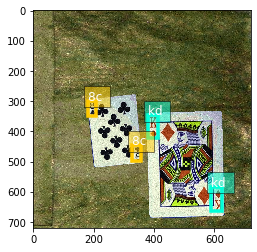

In [28]:
# Let's view this image with bounding boxes and classes
bboxes = train_label[:, :4]   # Get all elements :, and get all positions up to the 4th :4
cids = train_label[:, 4:5]    # Get the class ID in the 4th position
print('image:', train_image.shape)
print('bboxes:', bboxes.shape, 'class ids:', cids.shape)
ax = viz.plot_bbox(train_image.asnumpy(), bboxes, labels=cids, class_names=train_dataset.classes)
plt.show()

## Training